In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data
from src.model import build_and_sample_model
import matplotlib.pyplot as plt


# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'C:\Users\Owner\dev\algobetting\infra\data\db\fotmob.db',
    league='Premier_League', 
    season='2024-2025',
    max_goals=9,
    decay_rate=0.001,
    goals_weight=0.2,
    xg_weight=0.5,
    psxg_weight=0.3
)

# Ready for modeling!
home_idx = df['home_idx'].values
away_idx = df['away_idx'].values
home_goals_obs = df['home_goals'].values
away_goals_obs = df['away_goals'].values

df

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,match_id,match_date,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob,home_idx,away_idx
0,4506263,2024-08-16,Man United,Fulham,0,0,0.022120,281,False,0.020302,0.007456,0.057049,13,8
1,4506263,2024-08-16,Man United,Fulham,0,1,0.012338,281,False,0.009283,0.015801,0.024834,13,8
2,4506263,2024-08-16,Man United,Fulham,0,2,0.003045,281,False,0.001888,0.005104,0.005405,13,8
3,4506263,2024-08-16,Man United,Fulham,1,0,0.243230,281,True,0.112064,0.062784,0.138839,13,8
4,4506263,2024-08-16,Man United,Fulham,1,1,0.050435,281,False,0.051241,0.133064,0.060439,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11316,4506642,2025-02-22,Southampton,Brighton,1,7,0.003305,92,False,0.003672,0.003254,0.005657,16,4
11317,4506642,2025-02-22,Southampton,Brighton,1,8,0.001464,92,False,0.000936,0.000942,0.002806,16,4
11318,4506642,2025-02-22,Southampton,Brighton,1,9,0.000584,92,False,0.000170,0.000178,0.001237,16,4
11319,4506642,2025-02-22,Southampton,Brighton,2,3,0.000446,92,False,0.000983,0.000000,0.001027,16,4


In [2]:
def predict_weekly_simple(df, prediction_date, date_col='match_date'):
    """
    Simple version - just return MAE and basic calibration
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    prediction_date = pd.to_datetime(prediction_date)
    
    # Split data
    train_df = df[df[date_col] < prediction_date].copy()
    test_df = df[(df[date_col] >= prediction_date) & 
                 (df[date_col] < prediction_date + pd.Timedelta(days=7))].copy()
    
    # Filter to actual scorelines only for test
    if 'is_actual' in test_df.columns:
        test_df = test_df[test_df['is_actual'] == True].copy()
    
    if len(test_df) == 0:
        return None
    
    # Team mapping
    teams = sorted(set(df['home_team'].unique()) | set(df['away_team'].unique()))
    team_mapping = {team: idx for idx, team in enumerate(teams)}
    n_teams = len(teams)
    
    # Add indices
    train_df['home_idx'] = train_df['home_team'].map(team_mapping)
    train_df['away_idx'] = train_df['away_team'].map(team_mapping)
    test_df['home_idx'] = test_df['home_team'].map(team_mapping)
    test_df['away_idx'] = test_df['away_team'].map(team_mapping)
    
    # Model and predictions (using your existing build_and_sample_model function)
    model, trace = build_and_sample_model(train_df, n_teams, trace=1000, tune=500)
    
    # Get predictions
    test_home_idx = test_df['home_idx'].values
    test_away_idx = test_df['away_idx'].values
    
    att_str_samples = trace.posterior['att_str'].values.reshape(-1, n_teams)
    def_str_samples = trace.posterior['def_str'].values.reshape(-1, n_teams)
    home_adv_samples = trace.posterior['home_adv'].values.reshape(-1)
    baseline_samples = trace.posterior['baseline'].values.reshape(-1)
    
    n_samples = len(baseline_samples)
    sample_idx = np.random.choice(n_samples, size=500, replace=True)
    
    home_pred_mu = np.exp(
        baseline_samples[sample_idx, None] + 
        att_str_samples[sample_idx][:, test_home_idx] + 
        def_str_samples[sample_idx][:, test_away_idx] + 
        home_adv_samples[sample_idx, None]
    )
    
    away_pred_mu = np.exp(
        baseline_samples[sample_idx, None] + 
        att_str_samples[sample_idx][:, test_away_idx] + 
        def_str_samples[sample_idx][:, test_home_idx]
    )
    
    home_pred_mean = np.mean(home_pred_mu, axis=0)
    away_pred_mean = np.mean(away_pred_mu, axis=0)
    
    # Actual values
    actual_home = test_df['home_goals'].values
    actual_away = test_df['away_goals'].values
    
    # Simple metrics
    mae = np.mean(np.abs(np.concatenate([home_pred_mean, away_pred_mean]) - 
                        np.concatenate([actual_home, actual_away])))
    
    # Average goals per game
    avg_home_actual = np.mean(actual_home)
    avg_away_actual = np.mean(actual_away)
    avg_total_actual = avg_home_actual + avg_away_actual
    
    avg_home_pred = np.mean(home_pred_mean)
    avg_away_pred = np.mean(away_pred_mean)
    avg_total_pred = avg_home_pred + avg_away_pred
    
    return {
        'date': prediction_date,
        'mae': mae,
        'matches': len(test_df),
        'avg_home_actual': avg_home_actual,
        'avg_away_actual': avg_away_actual,
        'avg_total_actual': avg_total_actual,
        'avg_home_pred': avg_home_pred,
        'avg_away_pred': avg_away_pred,
        'avg_total_pred': avg_total_pred
    }

In [3]:
def run_weekly_analysis(df, start_date='2024-09-01', end_date='2024-12-01'):
    """
    Run analysis across multiple weeks and create simple charts
    """
    dates = pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='W-TUE')
    
    results = []
    print("Running weekly predictions...")
    
    for date in dates:
        result = predict_weekly_simple(df, prediction_date=date)
        if result:
            results.append(result)
            print(f"{date.date()}: MAE={result['mae']:.3f}, Matches={result['matches']}")
    
    if not results:
        print("No results to analyze")
        return
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Overall averages
    overall_mae = results_df['mae'].mean()
    overall_home_actual = results_df['avg_home_actual'].mean()
    overall_away_actual = results_df['avg_away_actual'].mean()
    overall_total_actual = results_df['avg_total_actual'].mean()
    overall_home_pred = results_df['avg_home_pred'].mean()
    overall_away_pred = results_df['avg_away_pred'].mean()
    overall_total_pred = results_df['avg_total_pred'].mean()
    
    # Print summary
    print(f"\n=== SUMMARY ===")
    print(f"Average MAE: {overall_mae:.3f}")
    print(f"Average goals per game:")
    print(f"  Home: Actual {overall_home_actual:.2f}, Predicted {overall_home_pred:.2f}")
    print(f"  Away: Actual {overall_away_actual:.2f}, Predicted {overall_away_pred:.2f}")
    print(f"  Total: Actual {overall_total_actual:.2f}, Predicted {overall_total_pred:.2f}")
    
    # Create charts
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # MAE chart
    ax1.plot(results_df['date'], results_df['mae'], 'bo-', linewidth=2)
    ax1.axhline(y=overall_mae, color='r', linestyle='--', alpha=0.7, label=f'Average: {overall_mae:.3f}')
    ax1.set_title('MAE by Week')
    ax1.set_ylabel('MAE')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Calibration chart
    ax2.plot(results_df['date'], results_df['avg_home_actual'], 'bo-', label='Home Actual')
    ax2.plot(results_df['date'], results_df['avg_home_pred'], 'b--', label='Home Predicted')
    ax2.plot(results_df['date'], results_df['avg_away_actual'], 'ro-', label='Away Actual')  
    ax2.plot(results_df['date'], results_df['avg_away_pred'], 'r--', label='Away Predicted')
    ax2.plot(results_df['date'], results_df['avg_total_actual'], 'ko-', label='Total Actual', linewidth=2)
    ax2.plot(results_df['date'], results_df['avg_total_pred'], 'k--', label='Total Predicted', linewidth=2)
    
    ax2.set_title('Average Goals per Game: Actual vs Predicted')
    ax2.set_ylabel('Goals per Game')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

Running weekly predictions...


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-09-10: MAE=0.991, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-09-17: MAE=1.009, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-09-24: MAE=0.884, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-10-01: MAE=1.191, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-10-15: MAE=0.855, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-10-22: MAE=0.805, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-10-29: MAE=0.779, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-11-05: MAE=0.898, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-11-19: MAE=1.146, Matches=10
2024-11-26: MAE=1.031, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-12-03: MAE=1.022, Matches=19


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-12-10: MAE=0.978, Matches=10


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-12-17: MAE=1.414, Matches=10


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-12-24: MAE=1.003, Matches=19


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2024-12-31: MAE=0.773, Matches=11


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-01-14: MAE=0.808, Matches=20
2025-01-21: MAE=0.942, Matches=10


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-01-28: MAE=1.287, Matches=10


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-02-11: MAE=0.912, Matches=11


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-02-18: MAE=1.162, Matches=11


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-02-25: MAE=0.876, Matches=10


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-03-04: MAE=0.732, Matches=10


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-03-11: MAE=0.783, Matches=8


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-04-01: MAE=0.810, Matches=20


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-04-08: MAE=0.948, Matches=10


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-04-15: MAE=1.136, Matches=11


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-04-22: MAE=0.681, Matches=9


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-04-29: MAE=1.002, Matches=11


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-05-06: MAE=1.055, Matches=10


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


2025-05-13: MAE=0.825, Matches=8


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


2025-05-20: MAE=0.884, Matches=12

=== SUMMARY ===
Average MAE: 0.956
Average goals per game:
  Home: Actual 1.54, Predicted 1.67
  Away: Actual 1.41, Predicted 1.48
  Total: Actual 2.95, Predicted 3.15


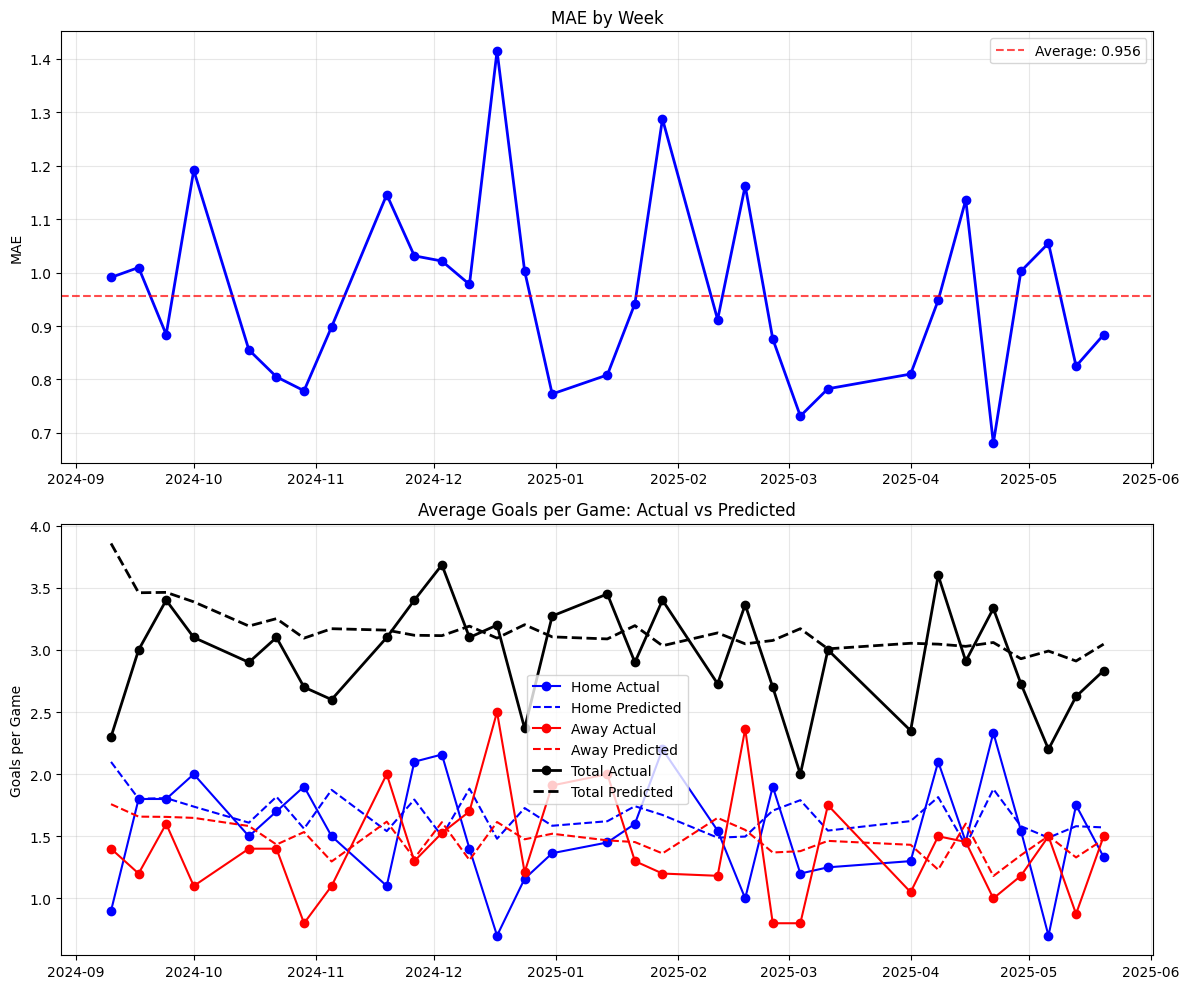

,date,mae,matches,avg_home_actual,avg_away_actual,avg_total_actual,avg_home_pred,avg_away_pred,avg_total_pred
0,2024-09-10,0.990887,10,0.900000,1.400000,2.300000,2.098429,1.758304,3.856733
1,2024-09-17,1.009418,10,1.800000,1.200000,3.000000,1.801785,1.658064,3.459849
2,2024-09-24,0.884066,10,1.800000,1.600000,3.400000,1.807040,1.655974,3.463014
3,2024-10-01,1.191258,10,2.000000,1.100000,3.100000,1.738903,1.647920,3.386823
4,2024-10-15,0.855324,10,1.500000,1.400000,2.900000,1.609353,1.582587,3.191940
5,2024-10-22,0.804906,10,1.700000,1.400000,3.100000,1.818314,1.433267,3.251581
6,2024-10-29,0.778925,10,1.900000,0.800000,2.700000,1.560625,1.533995,3.094620
7,2024-11-05,0.898394,10,1.500000,1.100000,2.600000,1.873525,1.297013,3.170539
8,2024-11-19,1.145728,10,1.100000,2.000000,3.100000,1.541317,1.617745,3.159062
9,2024-11-26,1.031262,10,2.100000,1.300000,3.400000,1.795464,1.322282,3.117746


In [4]:
results_df = run_weekly_analysis(df, start_date='2024-09-01', end_date='2025-06-01')

results_df